In [1]:
import pandas as pd
import datetime as dt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from pyLDAvis import sklearn as sklearn_lda
import re
import os
import numpy as np
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from nltk import tokenize
import pyLDAvis
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df1 = pd.read_hdf('EXAME_100pag.hdf', key = 'hdf')
df1.columns = ['Data','Titulo','Texto']
#df2 = pd.read_hdf('EXAME_100_300pag.hdf', key = 'hdf')

In [5]:
def data_transform(data):
    dict_data = {
        'jan': '01',
        'fev': '02',
        'mar': '03',
        'abr': '04',
        'maio': '05',
        'jun': '06',
        'jul': '07',
        'ago': '08',
        'set': '09',
        'out': '10',
        'nov': '11',
        'dez': '12'
    }
    
    data = data.split()
    data = data[:-1]
    data[1] = dict_data[data[1]]
    data[2] = data[2][:-1]
    data = '/'.join(data)
    return dt.datetime.strptime(data,'%d/%m/%Y')

In [6]:
df1['Data'] = df1['Data'].apply(data_transform)

In [7]:
df = df1.copy()

In [ ]:
df = df.sort_values(by='Data',ascending=False).reset_index(drop = True)
df = df.drop_duplicates(subset=['Titulo'], keep=False)

In [16]:
df_word = df.copy()

df_word['Texto'] = df_word['Texto'].apply(lambda x: x.split()) 

In [17]:
def word_transform(words):
    total = [x.lower() for x in words]
    total = [re.sub(r'[,\.!?()]', '', x) for x in total]
    manual_list_stop_words = ['ser','sobre','ainda','se','além', 'outros','porque','assim','ter', 'access_time', 'more_horiz',
                             'out','jun','publicado','diz','exame','patrocinado','ago','vip','abr',
                             'jul','jan','abr','set','nov','dez','conteúdo','mar','maio','estadão','marketing',
                             'fev','paulo', 'the','após', 'redação']
    stop_words = stopwords.words('portuguese')
    for i in manual_list_stop_words:
        stop_words.append(i)
    
    total = [x for x in total if x not in stop_words]
    total = [x for x in total if not re.search(r"\d", x)]
    
    long_string = (" ").join(total)
    return long_string

In [18]:
df_word['Texto'] = df_word['Texto'].apply(word_transform)

In [19]:
df_word.head()

,Data,Titulo,Texto
0,2019-10-25,"Com pegada tropical, Microsoft inaugura escrit...",pegada tropical microsoft inaugura escritório ...
1,2019-10-19,Gilmar suspende lei que proíbe ensino sobre or...,brasil gilmar suspende lei proíbe ensino orien...
2,2019-10-16,BRF abre 40 vagas de trainee com salário de R$...,carreira – s/a brf abre vagas trainee salário ...
3,2019-10-16,Facebook rivaliza com YouTube e Twitch com foc...,tecnologia facebook rivaliza youtube twitch fo...
4,2019-10-15,Sem “senhora”: Air Canada adota gênero neutro ...,negócios “senhora”: air canada adota gênero ne...


In [20]:
def plot_n_most_common_words(count_data, count_vectorizer, n):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 10/1.6180))
    plt.subplot(title=f'{n} most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

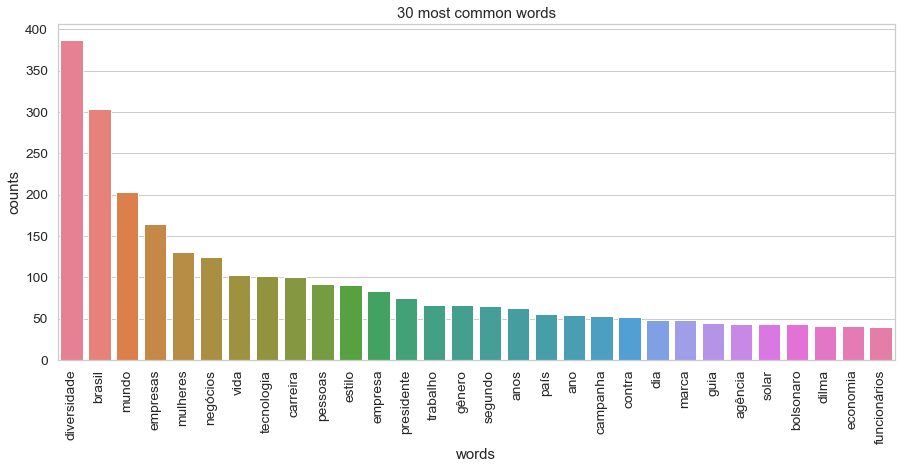

In [21]:
count_vectorizer = CountVectorizer()

count_data = count_vectorizer.fit_transform(df_word['Texto'])
                                               
plot_n_most_common_words(count_data, count_vectorizer,30)  

#### Wordcloud

In [108]:
wordcloud_string = ' '.join(df_word['Texto'].values)

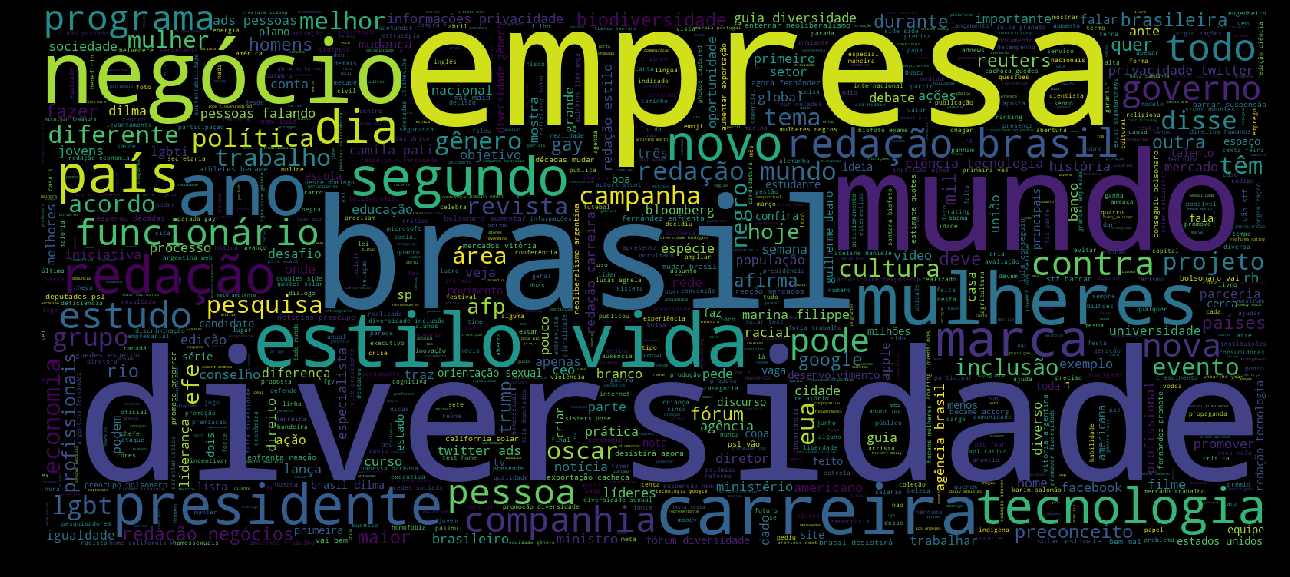

<Figure size 432x288 with 0 Axes>

In [109]:
wordcloud = WordCloud(max_words=1000,width=1600, height=700, contour_width=20)
wordcloud.generate(wordcloud_string)
plt.figure( figsize=(22,12), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.savefig('worcloud_Pasztor.png', facecolor='k', bbox_inches='tight')

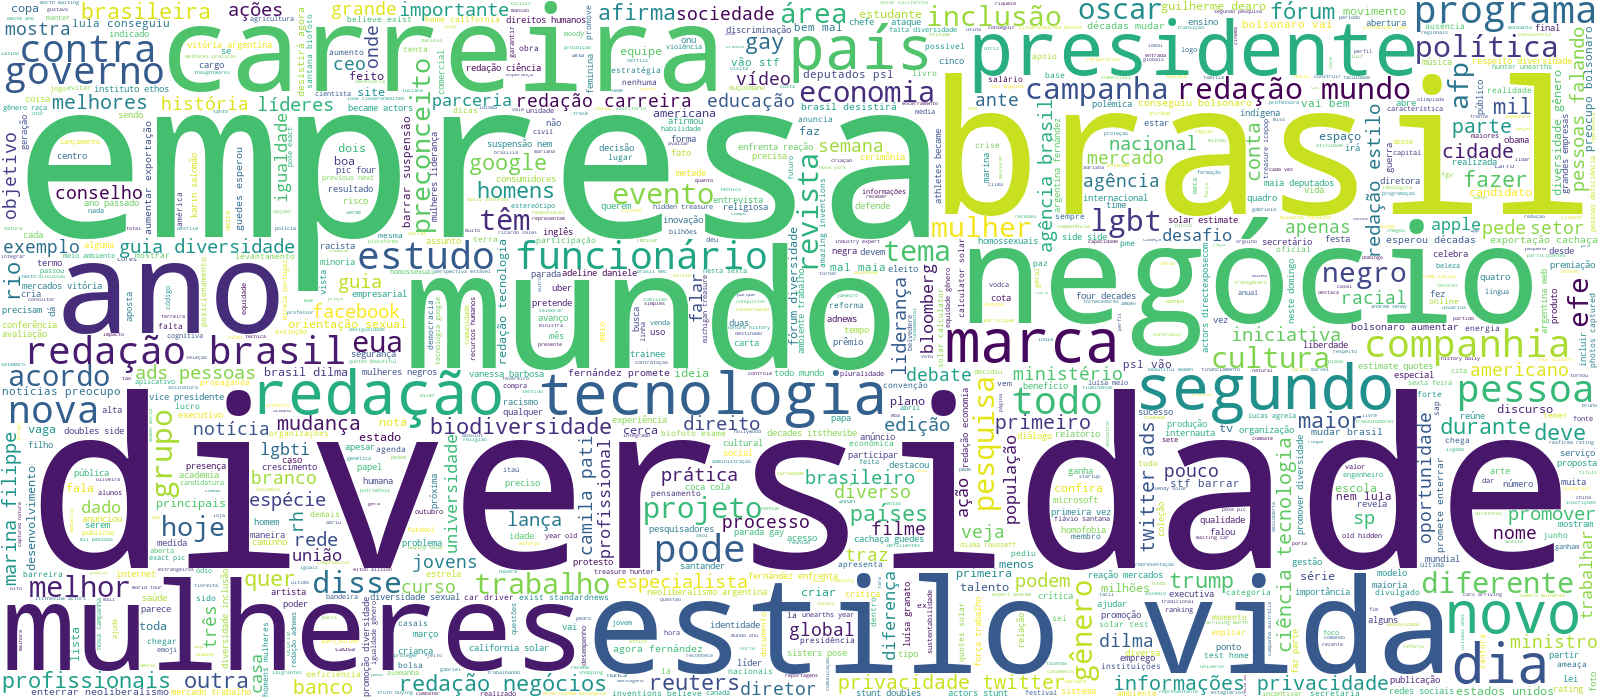

In [110]:
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=20,width=1600, height=700, contour_color='steelblue')
wordcloud.generate(wordcloud_string)
wordcloud.to_image()

#### Topic Modeling

In [22]:
count_vectorizer = CountVectorizer()

count_data = count_vectorizer.fit_transform(df_word['Texto'])

In [23]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 4
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
diversidade empresas brasil mundo

Topic #1:
diversidade mundo brasil mulheres

Topic #2:
brasil diversidade carreira dilma

Topic #3:
diversidade negócios mulheres empresas

Topic #4:
brasil diversidade mundo tecnologia


In [ ]:
%%time
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_setences'+'.html')